In [1]:
import shelve
import gdbm
mod = __import__('gdbm')
import dumbdbm
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets, decomposition
import numpy as np
import gc
from datetime import datetime
import datetime as dt
#datetime.strptime('2016-03-29','%Y-%d-%m')
import dateparser
from ipykernel import kernelapp as app
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from operator import itemgetter
import folium
from folium.plugins import HeatMap
import Instalib as IL
import math
import re
import string
import emoji
import pickle
import scipy.io
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
import sktensor
import geopy.distance
from itertools import groupby
import ncp
from datetime import timedelta
from dateutil.relativedelta import *

### 

# Open the file and have a first look

Read the data and concatenate in a single DataFrame file, basic file format for pandas. It's a 2-D object, tabular file with labeled rows and columns, built from a dictionary or such. 

More info about it here: https://pandas.pydata.org/pandas-docs/stable/10min.html

Make our life easier by matching the Torino labels with the Marseille ones and convert strings to datetime

In [2]:
df_new=pd.read_csv('/data/marcoq/instagram/torino/torino_posts.csv',lineterminator='\n')
df_new=df_new.rename(columns = {'caption':'text','taken_at_timestamp':'date'})
df_new.head()

,date,text,location_id
0,2017-11-14 16:20:42,After great week to home of my Friend this sac...,135250610358325
1,2017-10-31 16:10:00,Fisrt Flower of my new style.. thanx Teresa.. ...,135250610358325
2,2017-10-16 15:22:37,This for new roses!! Thanx Simone!!#walterbian...,135250610358325
3,2017-10-05 15:40:03,New skull !! #walterbianco_wb #wbtattooartgall...,135250610358325
4,2017-10-03 16:13:43,Paint acrilic biomech on sale 40cm X 30 cm o...,135250610358325


In [25]:
list_dates, Histo = IL.N_posts(df_new, debug=False)
Npostslog=[np.log10(H) for H in Histo]
Nposts=[H for H in Histo]

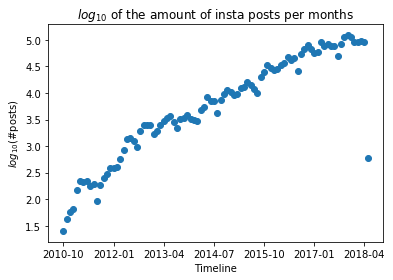

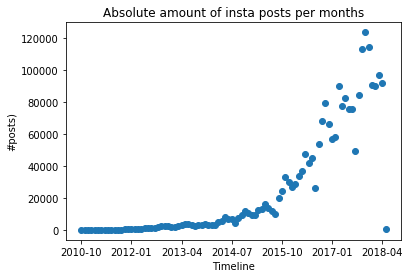

In [41]:
if 'Figures' not in os.listdir('.'):
    os.mkdir('Figures')
    os.mkdir('Figures/Shape')
    os.mkdir('Figures/Shape/Spatial')
    os.mkdir('Figures/Shape/Temporal')
plt.figure()
plt.scatter(list_dates, Npostslog)
plt.xticks(list_dates[0::15])
plt.ylabel(r'$log_{10}$(#posts)')
plt.xlabel('Timeline')
plt.title(r'$log_{10}$ of the amount of insta posts per months')
plt.savefig('Figures/Shape/Temporal/Torino_logN.pdf')
plt.show()
plt.figure()
plt.scatter(list_dates, Nposts)
plt.xticks(list_dates[0::15])
plt.ylabel('#posts)')
plt.xlabel('Timeline')
plt.title('Absolute amount of insta posts per months')
plt.savefig('Figures/Shape/Temporal/Torino_N.pdf')
plt.show()

In [99]:
df_location_all=pd.read_csv('/data/marcoq/instagram/torino/torino_locations.csv', lineterminator='\n')

In [100]:
df_location_all=df_location_all.rename(columns = {'latitude':'lat','longitude':'lon', 'location_id':'id'})
df_location_all.head()

,id,name,lat,lon
0,135250610358325,WB Tattoos Art Gallery,45.072270,7.693010
1,346586842349479,InQubatore Qulturale,45.133572,7.631137
2,328277161003275,Mixed By Luca Pain,45.081999,7.661826
3,1022295605,06565,45.063780,7.681740
4,127109984575725,Café Müller,45.061100,7.676030


In [ ]:
#remember zip:
zip([1,2,3],['a','b','c'])
#it's a function.

In [44]:
#make a new column 'coord' indexing (lat,lon) for each post
df_location_all['coord'] = list(zip(df_location_all.lat,df_location_all.lon))
df_location_all.head()

,id,name,lat,lon,coord
0,135250610358325,WB Tattoos Art Gallery,45.072270,7.693010,"(45.07227, 7.69301)"
1,346586842349479,InQubatore Qulturale,45.133572,7.631137,"(45.1335721884, 7.631136775)"
2,328277161003275,Mixed By Luca Pain,45.081999,7.661826,"(45.081999413, 7.6618255282)"
3,1022295605,06565,45.063780,7.681740,"(45.06378, 7.68174)"
4,127109984575725,Café Müller,45.061100,7.676030,"(45.0611, 7.67603)"


In [45]:
TbyCoord=IL.time_coord(df_location_all, df_new)

In [ ]:
#Global time heatmap
Coordinates=list(df_location_all.coord)
x = [C[0] for C in Coordinates]
y = [C[1] for C in Coordinates]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=1000)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

hmap = folium.Map(location=[np.mean(x), np.mean(y)], zoom_start=10, )

hm_wide = HeatMap( list(zip(x, y, heatmap)),
                   min_opacity=0.2,
                   max_val=max(Nposts),
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
hmap.add_child(hm_wide)
#hmap.save('Heatmaps/heatmap_global.html')

In [ ]:
#Heatmap per year
for year in range(2010,2019,1):
    Coordinates=[]
    for t in TbyCoord:
        if t[0][0:4]==str(year):
            Coordinates.append(t[1])
    x = [C[0] for C in Coordinates]
    y = [C[1] for C in Coordinates]

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=1000)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    hmap = folium.Map(location=[np.mean(x), np.mean(y)], zoom_start=14, )

    hm_wide = HeatMap( list(zip(x, y, heatmap)),
                   min_opacity=0.2,
                   max_val=max(Nposts),
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
    hmap.add_child(hm_wide)
    #hmap.save('heatmap'+str(year)+'.html')

# Let's refine the DataFrame

In [46]:
#link postID with its location
dict_id_coord= dict(zip(df_location_all.id,df_location_all.coord))
dict_id_name= dict(zip(df_location_all.id,df_location_all.name))
dict_coord_name= dict(zip(df_location_all.coord,df_location_all.name))

series.map() matches corresponding entries from two different series files. This is what x.map(y) does:

In [ ]:
x = pd.Series([1,2,3], index=['one', 'two', 'three'])
x

In [ ]:
y = pd.Series(['foo', 'bar', 'baz'], index=[1,2,3])
y

In [ ]:
x.map(y)

In [50]:
#Adding a column 'coords' by mapping the coordinates to their location_id:
df_new['coords'] = df_new['location_id'].map(dict_id_coord)
df_new['name'] = df_new['location_id'].map(dict_id_name)

#Create lat and lon columns by reading coords
# Look here: https://pythonhow.com/accessing-dataframe-columns-rows-and-cells/
df_new['lat']=[e[0] for e in df_new.loc[:,'coords']]
df_new['lon']=[e[1] for e in df_new.loc[:,'coords']]

# Drop duplicates
df_new.drop_duplicates(keep='first')
df_new.drop('location_id',axis=1,inplace=True)
df_new.head()

,date,text,coords,name,lat,lon
0,2017-11-14 16:20:42,After great week to home of my Friend this sac...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301
1,2017-10-31 16:10:00,Fisrt Flower of my new style.. thanx Teresa.. ...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301
2,2017-10-16 15:22:37,This for new roses!! Thanx Simone!!#walterbian...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301
3,2017-10-05 15:40:03,New skull !! #walterbianco_wb #wbtattooartgall...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301
4,2017-10-03 16:13:43,Paint acrilic biomech on sale 40cm X 30 cm o...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301


In [51]:
#needs to be done at the end for compatibility reasons
# learn how to parse time here: https://www.tutorialspoint.com/python/time_strptime.htm

df_new['date']=[datetime.strptime(t,'%Y-%m-%d %H:%M:%S') for t in list(df_new['date'])]

In [ ]:
df_new.dtypes

### Checkpoint 1

In [14]:
#pickle.dump(df_new, open('df_new_chkpt1.pkl', 'wb'))

Build the frame and the grid. $$x_{min/max}=longitude_{min/max}$$ and conversely for y and latitude.

In [52]:

# Attention problème d'arrondi lors du passage de Coord à (lat,lon)

lat1=min(df_new.lat)
lat2=max(df_new.lat)
lon1=min(df_new.lon)
lon2=max(df_new.lon)

In [53]:
# Generate the grid, step_m in km
step_m=0.5
step_lon=step_m/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
step_lat=step_m/(40000./360.)

In [54]:
# Define the repartition functions...
to_bin_lon = lambda x: np.floor(x / step_lon) * step_lon
to_bin_lat = lambda x: np.floor(x / step_lat) * step_lat
#... and distribute the points to the grid
df_new["latbin"] = df_new.lat.map(to_bin_lat)
df_new["lonbin"] = df_new.lon.map(to_bin_lon)
#Form the bins
#groups = df_new.groupby(["latbin", "lonbin"])
#compute the number of rows and columns
number_lats=(max(df_new['latbin'])-min(df_new['latbin']))/step_lat+1
number_lon=(max(df_new['lonbin'])-min(df_new['lonbin']))/step_lon+1
print (number_lats, number_lon)

(31.00000000000114, 31.000000000000007)


### Checkpoint 2

In [18]:
#pickle.dump(df_new, open('df_new_chkpt2.pkl', 'wb'))
#df_new=pd.read_pickle('df_new_chkpt2.pkl')

# Time to clean the text

But first make a copy before we do anything stupid

In [55]:
df_new_save=df_new.copy()
#df_new=df_new_save.copy()

In [56]:
#Purge all the newline characters
df_new['text']=df_new.text.replace('\n',' ',regex=True)
print df_new['text'][22].decode('utf-8')

purple 🤖 tenete d’occhio la playlist dei singoli ufficiali. la trovate su Spotify come “Mixed By Luca Pain”. tanto rap, trap e pop in arrivo. • link in bio per scoprire gli artisti che stanno uscendo con nuova musica e ascoltare i miei mix migliori • MBLP • direct per prenotare una rec sessionin studio • #studiodiregistrazione #mic #purple #microfono #registrazione #musica #lamusica #rap #dischi #album #artistatwork #artista #torino #turin #torinoèlamiacittà #torinocity  #passione #lavoro #ognigiorno #supreme #trap #xxxtentacion #liluzivert #lilpump #drop #music #radio #sogno #palco


In [57]:
len(df_new.text.tolist())

2260544

This methods works only on unicode text. So we need to use the function x.decode('utf-8') to convert all strings in the 'text' field to unicode objects.

In [58]:
text_0=df_new['text'][22][0:11].decode('utf-8')
print text_0

purple 🤖


In [59]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
#df_new['text_new2'] = df_new['text_new2'].map(lambda x: emoji_pattern.sub(r'', x))
       
#It works on unicode but not on a string:
    
text = u'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

text = 'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print '\n but some emojis still pass through... \n'

text=text_0
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji


This dog 😂
This dog 
This dog \U0001f602
This dog \U0001f602

 but some emojis still pass through... 

purple 🤖
purple 🤖
purple 🤖
purple 🤖


Another way to deal with emoji would be to de-emojize them. They would then count as words, that can either be removed
since they have the very peculiar following form :grinning_face: 

The difficulty here is identifying emojis in a text. Their classification is hard to decypher

In [60]:
print(text) # with emoji
print emoji.demojize(text) # no emoji

purple 🤖
purple :robot_face:


In [61]:
#Remove all blank fields and encode everything in utf-8 if it is not already the case
df_new=df_new[df_new['text'].notnull()]
if not type(df_new['text'][0])==unicode:
    df_new['text']=df_new['text'].map(lambda x: x.decode('utf-8'))

In [ ]:
#This works but it takes forever

def rem_emj(unicode_string,keys):
    """Removes words found in keys from unicode_string.
    
    Works to remove emojis by setting keys to emoji.unicode_codes.UNICODE_EMOJI.keys()"""
    ret=u''
    for i in unicode_string:
        if not i in keys:
            ret+=i
    return ret

In [68]:
#remove emojis? some of them still pass through
#re.sub(a,b,string) = remplace le premier a par b dans string et renvoie string. 
#Si a n'est pas dans string, renvoie string.
keys=emoji.unicode_codes.UNICODE_EMOJI.keys()
df_new['text_new'] = df_new['text'].map(lambda x: emoji_pattern.sub(r'', x))
#df_new['text_new'] = df_new['text'].map(lambda x: rem_emj(x,keys)) 

In [70]:
#remove hyperlinks
df_new['text_new'] = df_new['text_new'].map(lambda x: re.sub(r'http\S+', '', x))

In [71]:
#remove quotes
df_new['text_new'] = df_new['text_new'].map(lambda x: re.sub(r'&amp;quot;|&amp;amp', ' ', x))

In [72]:
#Remove tags
df_new['text_new'] = df_new['text_new'].map(lambda x: re.sub(r'@[a-zA-Z0-9]*', '', x))

In [73]:
#Remove tickers
df_new['text_new']= df_new['text_new'].map(lambda x: re.sub(r'\$[a-zA-Z0-9]*', '', x))

In [74]:
#Remove numbers
df_new['text_new']=df_new['text_new'].map(lambda x:  re.sub(r'[0-9]*','',x))

In [75]:
#Remove #
df_new['text_new']=df_new['text_new'].map(lambda x:  re.sub(r'#*','',x))

In [76]:
#Remove punctuation
df_new.text_new = [filter(lambda x: x not in string.punctuation,tweet) for tweet in df_new.text_new]

In [80]:
#print len(df_new.text_new)
df_new.head(10)

,date,text,coords,name,lat,lon,latbin,lonbin,text_new
0,2017-11-14 16:20:42,After great week to home of my Friend this sac...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,After great week to home of my Friend this sac...
1,2017-10-31 16:10:00,Fisrt Flower of my new style.. thanx Teresa.. ...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Fisrt Flower of my new style thanx Teresa than...
2,2017-10-16 15:22:37,This for new roses!! Thanx Simone!!#walterbian...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,This for new roses Thanx Simonewalterbiancowb ...
3,2017-10-05 15:40:03,New skull !! #walterbianco_wb #wbtattooartgall...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,New skull walterbiancowb wbtattooartgallery w...
4,2017-10-03 16:13:43,Paint acrilic biomech on sale 40cm X 30 cm o...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Paint acrilic biomech on sale cm X cm origi...
5,2017-09-28 13:52:45,"Ready for this cover sleeve, after 15 years go...","(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Ready for this cover sleeve after years go to...
6,2017-09-23 16:23:30,Little speed scketch for this biomech#walterbi...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Little speed scketch for this biomechwalterbia...
7,2017-09-20 12:41:30,"Yes after Time, now this sleeve whit genoma an...","(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Yes after Time now this sleeve whit genoma and...
8,2017-09-16 19:26:29,#tatooo#wbtattoos#liontatoo#art#happiness #fin...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,tatooowbtattoosliontatooarthappiness finalment...
9,2017-09-09 14:14:29,Si comincia!! #stencil#tattoo#tattoos#wb#wbtat...,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Si comincia stenciltattootattooswbwbtattooswbt...


In [81]:
#encoding back in strings
df_new['text_new'] = df_new['text_new'].map(lambda x: x.encode('utf-8'))

In [32]:
df_new=df_new[df_new['text_new'].notnull()]
df_new=df_new[df_new['text_new'] != '']
df_new=df_new[['date','lat','lon','latbin','lonbin','coords','text_new','name']]
df_new=df_new.rename(columns = {'text_new':'text'})
df_new['coordsbin'] = list(zip(df_new.latbin,df_new.lonbin))
df_new.head()

KeyError: 'text_new'

### Checkpoint 3

In [19]:
#And pickle it
#df_new.to_pickle('df_new_chkpt3.pkl')
#df_new=pd.read_pickle('df_new_chkpt3.pkl')
#df_new=df_new[df_new['text'] != '']

In [ ]:
if False:
    #In case I'm not loading this since the beginning
    lat1=min(df_new.lat)
    lat2=max(df_new.lat)
    lon1=min(df_new.lon)
    lon2=max(df_new.lon)
    step_m=0.5
    step_lon=step_m/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
    step_lat=step_m/(40000./360.)
    # Define the repartition functions...
    to_bin_lon = lambda x: np.floor(x / step_lon) * step_lon
    to_bin_lat = lambda x: np.floor(x / step_lat) * step_lat
    #compute the number of rows and columns
    number_lats=(max(df_new['latbin'])-min(df_new['latbin']))/step_lat+1
    number_lon=(max(df_new['lonbin'])-min(df_new['lonbin']))/step_lon+1
    print (number_lats, number_lon)`
    df_new.head()

In [85]:
dict_coord_name= dict(zip(df_new.coords,df_new.name))
dict_name_coord= dict(zip(df_new.name,df_new.coords))

Learn about how groupby does not returns a dataframe but only groups the data IN ORDER TO APPLY SOME FUNCTION to it here: https://pandas.pydata.org/pandas-docs/stable/groupby.html

In [36]:
temp_df=df_new.copy()
# Let's make a list of coordinates associated to each place and store them in a pd.Series
A=temp_df.groupby('name')['coords'].apply(lambda x : x.tolist())
B=temp_df.groupby('coords')['name'].apply(lambda x : x.tolist())
# Idem but with the bins associated to each place
Abin=temp_df.groupby('name')['coordsbin'].apply(lambda x : x.tolist())
Bbin=temp_df.groupby('coordsbin')['name'].apply(lambda x : x.tolist())

# A is a pd.Series with the place names for indices and the coordinates for values.
# B is the opposite pd.Series.

# Abin and Bbin are the same but using the coordinates of the bin associated to each place.

degenerate_datapoints=0
Degenerate_loc=[]
Degenerate_names=[]
Degenerate_freq=[]
# For every place in A
for a in A.index:
    # if we have more than one coordinate for this place
    if len(set(A[a])) != 1:
        degenerate_datapoints+=len(A[a])
        #Store the place name, coordinates and relative frequencies in 3 lists of lists.
        Degenerate_loc.append(list(set(A[a])))
        Degenerate_names.append(a)
        Degenerate_freq.append([(key,len(list(group))) for key, group in groupby(A[a])])
print 'BEFORE BINNING:'
print degenerate_datapoints, ' degenerate datapoints in the dataset.'
print 100*degenerate_datapoints/df_new.shape[0], '% of degenerate data'

degenerate_datapoints=0
Degenerate_locbin=[]
Degenerate_namesbin=[]
# For every place in A
for a in Abin.index:
    # if we have more than one bin for this place
    if len(set(Abin[a])) != 1:
        #Store the place name and bin 2 lists of lists.
        degenerate_datapoints+=len(Abin[a])
        Degenerate_locbin.append(list(set(Abin[a])))
        Degenerate_namesbin.append(a)
print 'AFTER BINNING:'
print degenerate_datapoints, ' degenerate datapoints in the dataset.'
print 100*degenerate_datapoints/df_new.shape[0], '% of degenerate data'

# Binning the values does not help: The coordinates associated to some places are too far
# away from each other to be coarsegrained. How come such different locations could be
# associated with the same place? 
# Some of those are restaurants or supermarkets chains. Some others have only episodic 
# locations that don't fit the usual one.

BEFORE BINNING:
384143  degenerate datapoints in the dataset.
19 % of degenerate data
AFTER BINNING:
274775  degenerate datapoints in the dataset.
13 % of degenerate data


In [37]:
# Now compute the pairwise distance to have an idea of the area associated to those places.
distances=[]
Degloc_copy=np.copy(Degenerate_loc)
for d in Degloc_copy:
    dist_d=[]
    e=list(np.copy(d))
    while e:
        #take the first point as reference to compute its distance to the other ones
        ref=e.pop()
        for point in e:
            try:
                dist_d.append(geopy.distance.distance(ref,point).km)
            except IndexError:
                pass
    distances.append(dist_d)
    
Deg_names_dist=list(zip(Degenerate_names,distances))

In [38]:
# Find the relative frequencies of the different locations associated 
# to each degenerated place
Resp_freq=[[i[1] for i in e] for e in Degenerate_freq]
Resp_freq=[[float(i)/sum(e) for i in e] for e in Resp_freq]
# zip(Resp_freq,distances)

In [39]:
bin_dist=geopy.distance.distance((45.108768700000006, 7.6410829),(45.108768700000006+step_lat,step_lon+ 7.6410829)).km
print 'The diagonal of the grid unit cell is typically ',bin_dist,' km.'
print len([d for d in distances if np.mean(d)>bin_dist]), ' places have typical pairwise distances bigger than this distance.'

The diagonal of the grid unit cell is typically  0.708205755171  km.
60  places have typical pairwise distances bigger than this distance.


In [40]:
# List of the degenerated places with their relative frequencies, names 
# and typical pairwisedistance.

C=zip(Resp_freq,Degenerate_names,distances)
for c in C:
    # If one coordinate has a frequency much higher than the others
    if max(c[0])>.95:
        # And if the average pairwise distance is bigger than a threshold
        if np.mean(c[2])>1:
            print c[1], Degenerate_loc[Degenerate_names.index(c[1])], np.mean(c[2])
# How to access coordinates of one of those places:
print Degenerate_loc[Degenerate_names.index('Dallatte')]
print Degenerate_loc[Degenerate_names.index('Campus Luigi Einaudi')]

Allianz Stadium Curva Sud [(45.108768700000006, 7.6410829), (45.0667, 7.7)] 6.585742316054901
Collina Di Torino [(45.01228384, 7.73264413), (45.05392, 7.69915)] 5.326974771248154
Fujiyama Ristorante Giapponese [(45.05757, 7.67733), (45.06785, 7.7128)] 3.0182175479128475
Giancarlo [(45.0572133, 7.646631299999999), (45.06507, 7.69822)] 4.156030885963382
Murazzi [(45.0667, 7.7), (45.0727356263, 7.668650234099999)] 2.558327502560891
Piazza Castello [(45.0707768953, 7.685123252), (45.078579336400004, 7.636950966000001)] 3.891139696332791
Torino [(45.072768865, 7.6702275208), (45.0667859, 7.6921288), (45.0606489, 7.692784700000001), (45.0932508, 7.679447), (45.0692678024, 7.6836709345)] 1.9761068437941698
[(45.0229, 7.64843), (45.03464, 7.66833)]
[(45.074122521199996, 7.6996772548), (45.07411, 7.69999)]


In [41]:
# How many places have associated coordinates further apart than an arbitrary threshold t?
# What are those places and what are their locations?

t=.7 #threshold in km
ct=0
for d in Deg_names_dist:
    if any( e>t for e in d[1]):
        ct+=1
        print d[0], '&', Degenerate_loc[Deg_names_dist.index(d)],'&', np.mean(d[1]),'\\\\'
print ct,'places above this distance threshold in a list of ', len(Deg_names_dist)

Allianz Stadium Curva Sud & [(45.108768700000006, 7.6410829), (45.0667, 7.7)] & 6.585742316054901 \\
America Graffiti & [(45.110009999999996, 7.64554), (45.06393, 7.68537)] & 6.00480307112087 \\
Auchan & [(45.119679999999995, 7.71397), (45.1137962, 7.6447269)] & 5.487598713112936 \\
Brek & [(45.056673705600005, 7.612859129099999), (45.064369899999996, 7.679469999999999)] & 5.315783546116205 \\
Bunet & [(45.06995, 7.68688), (45.06439, 7.649589999999999)] & 3.0010608244676797 \\
Caffè Vergnano 1882 & [(45.06006, 7.68815), (45.07065, 7.67975), (45.06157, 7.68277)] & 0.947532803581852 \\
Capatoast & [(45.06646, 7.693110000000001), (45.063359999999996, 7.6817)] & 0.9624019770660424 \\
Carrefour Italia & [(45.053509000000005, 7.651069099999999), (45.0069299, 7.62398), (45.05775, 7.6609300000000005), (45.0661842149, 7.630446405700001), (45.1013008938, 7.591435110499999)] & 5.435169209717322 \\
Collina Di Torino & [(45.01228384, 7.73264413), (45.05392, 7.69915)] & 5.326974771248154 \\
Corso Un

In [42]:
# All locations associated with a degenerated place
Degloc_all=[]
for p in Degloc_copy:
    for d in p:
        Degloc_all.append(d)

In [43]:
# Link the locations associated to a place in particular to visualise what it means.
m = folium.Map(location=[np.mean([c[0] for c in Degloc_all]),np.mean([c[1] for c in Degloc_all])], zoom_start=12)
#for p in Degloc_all:
 #   folium.Marker(p).add_to(m)
for p in Degloc_copy:
    p.append(p[0])
    folium.PolyLine(locations=p).add_to(m)
m
#m.save('places_hiN.html')

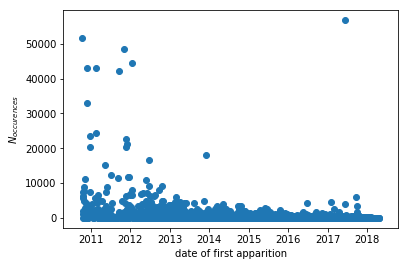

In [44]:
# Plot the N_posts for each place as a function of their earliest occurence in the dataset. 
temp_df=df_new.copy()
# group data by name, then compute the size of each group and store that in a dict
dict_places_n=temp_df.groupby('name').count()['text'].to_dict()
# Same but instead of the size compute the minimum date in each group (earliest occurence)
dict_places_fdate=temp_df.groupby('name').apply(lambda x : x['date'].min()).to_dict()

N_fdate=[]
for k in dict_places_n.keys():
    N_fdate.append((dict_places_n[k],dict_places_fdate[k],k))
    
plt.figure()
plt.scatter([n[1] for n in N_fdate],[n[0] for n in N_fdate])
plt.xlabel('date of first apparition')
plt.ylabel(r'$N_{occurences}$')
#plt.savefig('N_data_first_apparition.pdf')
plt.show()

In [45]:
Outliers=[]
# Who are the outliers of the two last years (The places with a number of posts too high)
# But not extremely high.
for n in N_fdate:
    if n[1].year>=2016:
        if n[0]>=2000 and n [0]<10000:
            Outliers.append((n[2],n[0]))
    if n[1].year>=2017:
        if n[0]>=1500 and n [0]<2000:
            Outliers.append((n[2],n[0]))
Outliers=[(e[0], e[1], dict_name_coord[e[0]]) for e in Outliers]
Outliers

NameError: name 'dict_name_coord' is not defined

In [98]:
Places_to_get=[]
# How to access the points which are out of the general tendency (monuments, etc. ?)
for k in dict_places_n.keys():
    if dict_places_n[k]>10000:
        Places_to_get.append([dict_name_coord[k],dict_places_n[k]])

#Places_to_get is a list of [(lat,lon), N_post] for the places with a unusually high N_post.

Allianz Stadium 45010


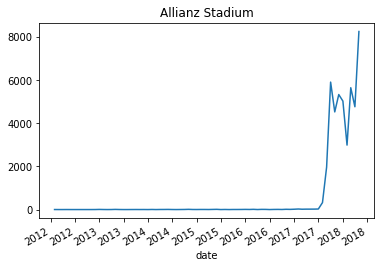

Venaria Reale 25080


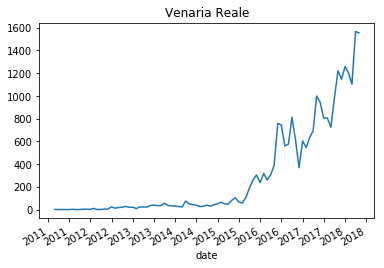

Lingotto Fiere - Torino 21362


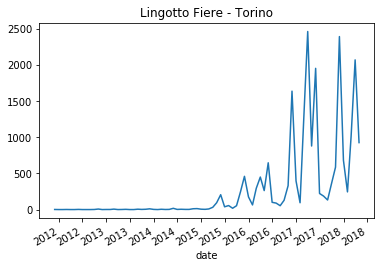

Piazza Castello 52850


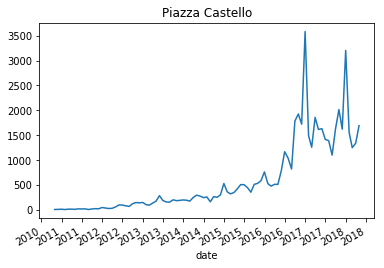

Piazza Vittorio Veneto 33802


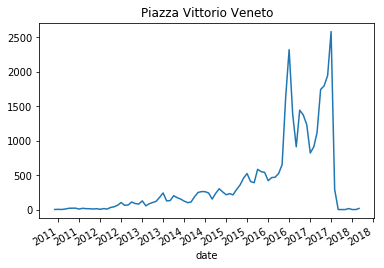

Torino Centro 58361


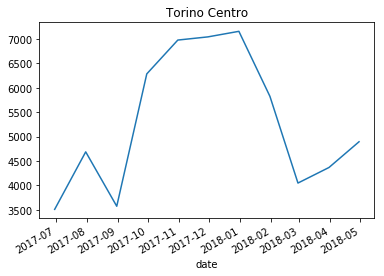

Museo Egizio, Torino 24014


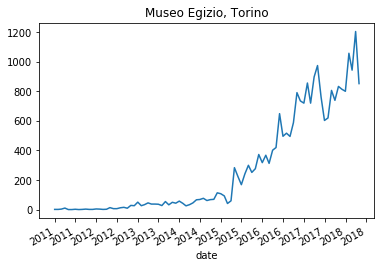

Piazza San Carlo 43854


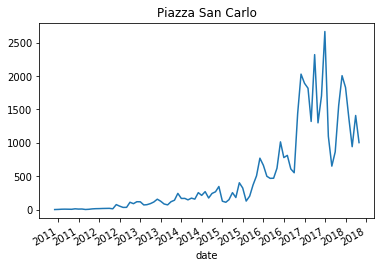

Politecnico di Torino 12603


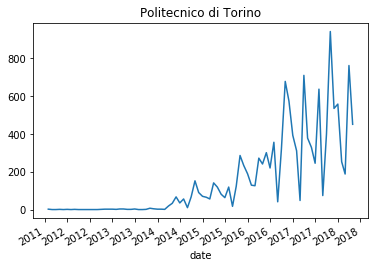

Settimo Torinese 17180


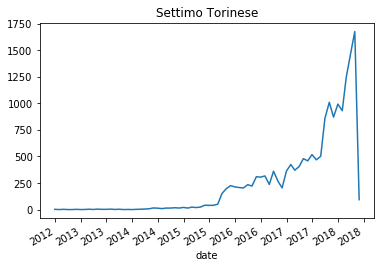

Pala Alpitour 42589


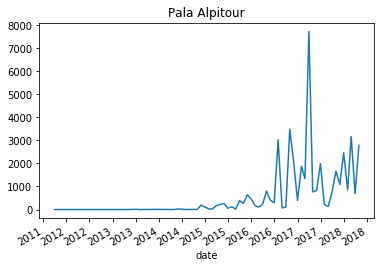

Mole Antonelliana 43888


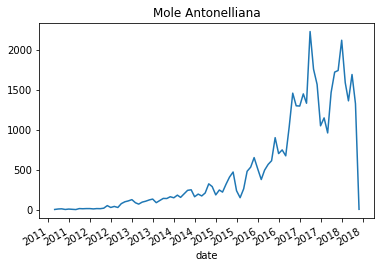

Murazzi del Po 15590


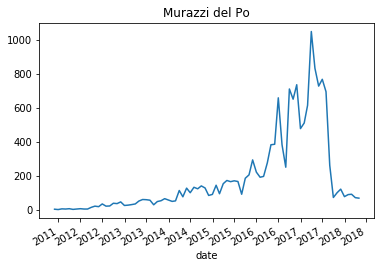

Juventus Stadium 11781


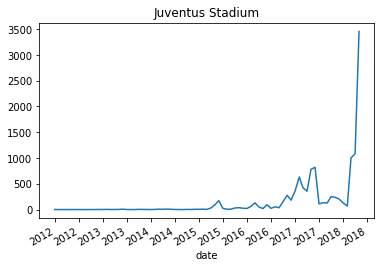

Parco del Valentino 50117


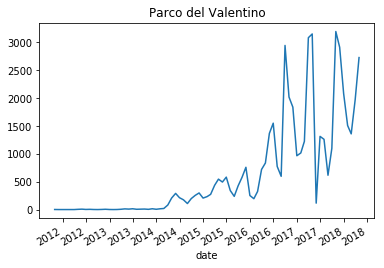

Regina Margherita, Piemonte, Italy 12190


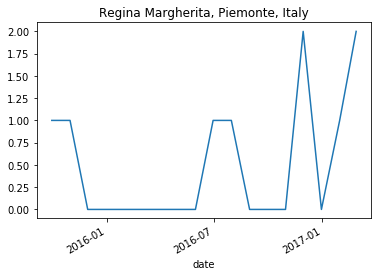

Reggia Di Venaria 18482


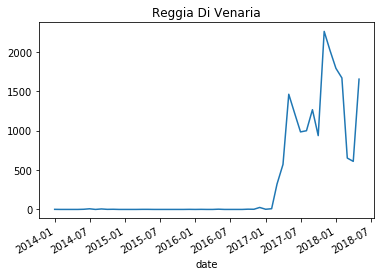

Torino, Italy 20728


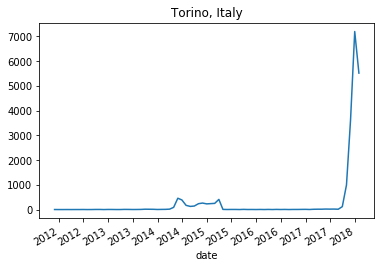

Stadio Grande Torino - Olimpico 10873


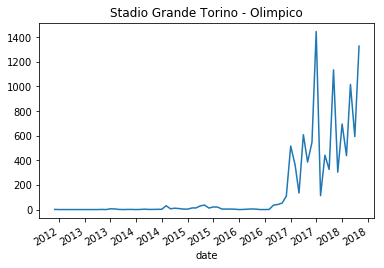

Stadio Olimpico 11371


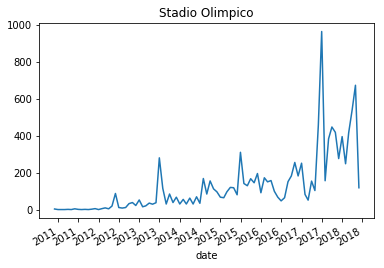

Torino Porta Nuova 20742


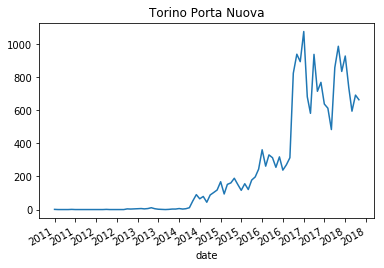

Monte dei Cappuccini 23452


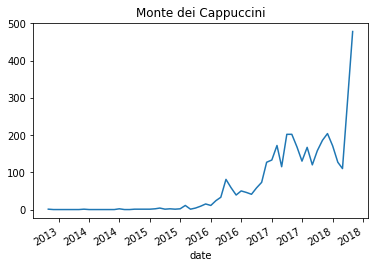

Superga, Piemonte, Italy 11741


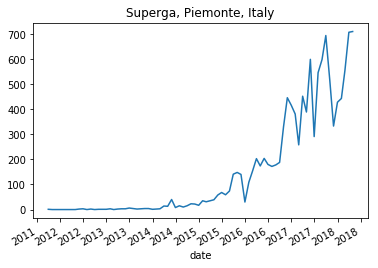

In [104]:
# There would be more elegant way to do it, probably.
# using groupby('name').resample().count().plot() ?

time_series=df_new.copy()
# let's plot the time series for each of those "places to get".
time_series["date"] = time_series["date"].astype("datetime64")

if not 'TimeSeriesPopPlaces' in os.listdir('.'):
    os.mkdir('TimeSeriesPopPlaces')

for p in Places_to_get:
    #PlaceName is the name of the place
    PlaceName= dict_coord_name[p[0]]
    print PlaceName, p[1]
    # Keep only the data where the field name matches PlaceName
    time_series=df_new.loc[df_new['name'] == PlaceName]
    time_series.set_index('date', drop=False, inplace=True)
    #Resample data on a monthly 'M' frequency and plot it with matplotlib
    ax = time_series.text.resample('M').count().plot(x_compat=True)
    #The hashtag Torino Centro lasts for only a year, it is not enough to have a tick every 6 moths
    if PlaceName=='Torino Centro':
    # elsewhere data spans over several years, so a tick in Jan and one in Jul is enough.
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,7]))
    ax.xaxis.set_label('timeline')
    ax.yaxis.set_label(r'N_{occurences}')
    ax.set_title(PlaceName)
    plt.savefig('TimeSeriesPopPlaces/'+PlaceName.replace(' ', '_')+'.pdf')
    plt.show()

In [105]:
# Where are the places that gather so much posts, on a map?
m = folium.Map(location=[np.mean([c[0][0] for c in Places_to_get]),np.mean([c[0][1] for c in Places_to_get])], zoom_start=12)
for p in Places_to_get:
    folium.Marker(p[0]).add_to(m)
m
#m.save('places_hiN.html')

In [106]:
# Hotspot = coordinates associated with several posts.
# How many different hotspots do we have? 
df_new_index_cells=df_new.copy()
# group the posts by coordinates and agglomerate the text in each of them
df_new_index_cells['text'] = df_new_index_cells.groupby(['coords'])['text'].transform(lambda x: ','.join(x))
# Keep only one occurence for each hotspot
df_new_nodup_cells=df_new_index_cells[['latbin','lonbin','coords']].drop_duplicates()
print 'How many spots?', df_new_nodup_cells.shape[0]
df_new_nodup_cells.head()

How many spots? 5819


,latbin,lonbin,coords
0,45.0720,7.691152,"(45.07227, 7.69301)"
14,45.1305,7.627431,"(45.1335721884, 7.631136775)"
21,45.0810,7.659292,"(45.081999413, 7.6618255282)"
43,45.0630,7.678408,"(45.06378, 7.68174)"
78,45.0585,7.672036,"(45.0611, 7.67603)"


In [119]:
print len(set(df_new_nodup_cells.coords.tolist())), 'different coordinates in the dataset'

5819 different coordinates in the dataset


In [109]:
# Create a DataFrame with the grid coordinates of each hotspot.
# n is the global index of each element in the grid matrix:
# [1 2 3]
# [4 5 6]
# [7 8 9]

df_new_nodup_cells['row']=(max(df_new_nodup_cells['lonbin'])-df_new_nodup_cells['lonbin'])/step_lon
df_new_nodup_cells['column']=(df_new_nodup_cells['latbin']-min(df_new_nodup_cells['latbin']))/step_lat
df_new_nodup_cells['(r,c)'] = list(zip(df_new_nodup_cells['row'],df_new_nodup_cells['column']))
df_new_nodup_cells['n'] = (df_new_nodup_cells['row'])*number_lats+df_new_nodup_cells['column']
df_new_nodup_cells.head()

,latbin,lonbin,coords,row,column,"(r,c)",n
0,45.0720,7.691152,"(45.07227, 7.69301)",12.0,15.0,"(12.0, 15.0)",387.0
14,45.1305,7.627431,"(45.1335721884, 7.631136775)",22.0,28.0,"(22.0, 28.0)",710.0
21,45.0810,7.659292,"(45.081999413, 7.6618255282)",17.0,17.0,"(17.0, 17.0)",544.0
43,45.0630,7.678408,"(45.06378, 7.68174)",14.0,13.0,"(14.0, 13.0)",447.0
78,45.0585,7.672036,"(45.0611, 7.67603)",15.0,12.0,"(15.0, 12.0)",477.0


In [110]:
#And index it by coordinates
df_new_nodup2_cells=df_new_nodup_cells.copy()
df_new_nodup2_cells=df_new_nodup2_cells.set_index(['coords'])

In [111]:
#Make an index of only the years + months and text of posts
df_new_index=df_new[['date','text','coordsbin']]
df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [112]:
# df_new_index is a dataframe with a column month_abs that puts every
# month on a global timeframe.

df_new_index.head()

,date,text,coordsbin,year_month,month_abs
0,2017-11-14 16:20:42,After great week to home of my Friend this sac...,"(45.072, 7.69115211839)","(2017, 11)",95
1,2017-10-31 16:10:00,Fisrt Flower of my new style thanx Teresa than...,"(45.072, 7.69115211839)","(2017, 10)",94
2,2017-10-16 15:22:37,This for new roses Thanx Simonewalterbiancowb ...,"(45.072, 7.69115211839)","(2017, 10)",94
3,2017-10-05 15:40:03,New skull walterbiancowb wbtattooartgallery w...,"(45.072, 7.69115211839)","(2017, 10)",94
4,2017-10-03 16:13:43,Paint acrilic biomech on sale cm X cm origi...,"(45.072, 7.69115211839)","(2017, 10)",94


In [122]:
print df_new_index.shape
print len(set(df_new_index.text.tolist()))
print len(df_new_index.text.tolist())
print len(set(df_new_index.coordsbin.tolist()))
print len(df_new_index.coordsbin.tolist())

(2040821, 5)
1831300
2040821
518
2040821


### Checkpoint 4

In [46]:
#And pickle it
#df_new_index.to_pickle('df_new_index_chkpt4.pkl')
df_new_index=pd.read_pickle('df_new_index_chkpt4.pkl')
df_new_index=df_new_index[df_new_index['text'] != '']

In [51]:
list_years=list(set([e[0] for e in df_new_index.year_month.tolist()]))
list_months=list(set([e[1] for e in df_new_index.year_month.tolist()]))
print sorted(list_years)
print sorted(list_months)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [52]:
def TimeFlags(start,stop,granularity,n_gran):
    flags=[start]
    if granularity=='months':
        T_delta=relativedelta(months=n_gran)
    elif granularity=='days':
        T_delta=relativedelta(days=n_gran)        
    while flags[-1]+T_delta<stop:
        flags.append(flags[-1]+T_delta)
    return flags
start=datetime(2017,1,3)
stop=datetime(2017,12,3)
flags=TimeFlags(start,stop,'days',15)
slices=[(f,f+relativedelta(months=1)) for f in flags]

In [53]:
start=datetime(2010,10,1)
stop=datetime(2018,12,12)
flags=TimeFlags(start,stop,'months',1)
slices=[(f,f+relativedelta(months=1)) for f in flags]

In [75]:
# My version NEW
df_classified=pd.DataFrame()
for flag in slices:
        #Select only the data corresponding to this month
        df_sliced= df_new_index[(df_new_index['date']>=flag[0]) & (df_new_index['date']<=flag[1])]
        gc.collect()
        #Group the data by bin and join the text of all the posts grouped this way
        print flag[0].date(),flag[1].date(), len(set(df_sliced['text'].tolist()))
        try:
            df_sliced['text'] = df_sliced.groupby('coordsbin')['text'].transform(lambda x: ','.join(x))
        except ValueError, e:
            print repr(e)
            continue
        #drop the potential duplicates
        # Some posts, at various dates, have the same text in them. We keep only the
        # first occurence and discard the next ones.
        df=(df_sliced[['text','coordsbin']].drop_duplicates())
        df.set_index('coordsbin', inplace=True)
        df.rename(columns={"text": slices.index(flag)},inplace=True)
        df_classified=df_classified.merge(df, how='outer', left_index=True,right_index=True)
df_classified.fillna(value='',inplace=True)
series_list = [df_classified[c] for c in df_classified.columns[:-1]]
# concatenate:
df_classified['result'] = [s.strip() for s in series_list[0].str.cat(series_list[1:], sep=' ')]
df_classified.head()

2010-10-01 2010-11-01 20


/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


2010-11-01 2010-12-01 39
2010-12-01 2011-01-01 50
2011-01-01 2011-02-01 47
2011-02-01 2011-03-01 124
2011-03-01 2011-04-01 165
2011-04-01 2011-05-01 148
2011-05-01 2011-06-01 173
2011-06-01 2011-07-01 122
2011-07-01 2011-08-01 142
2011-08-01 2011-09-01 68
2011-09-01 2011-10-01 138
2011-10-01 2011-11-01 177
2011-11-01 2011-12-01 206
2011-12-01 2012-01-01 258
2012-01-01 2012-02-01 269
2012-02-01 2012-03-01 288
2012-03-01 2012-04-01 392
2012-04-01 2012-05-01 573
2012-05-01 2012-06-01 918
2012-06-01 2012-07-01 986
2012-07-01 2012-08-01 866
2012-08-01 2012-09-01 667
2012-09-01 2012-10-01 1385
2012-10-01 2012-11-01 1761
2012-11-01 2012-12-01 1761
2012-12-01 2013-01-01 1834
2013-01-01 2013-02-01 1272
2013-02-01 2013-03-01 1456
2013-03-01 2013-04-01 1879
2013-04-01 2013-05-01 2200
2013-05-01 2013-06-01 2562
2013-06-01 2013-07-01 2724
2013-07-01 2013-08-01 2268
2013-08-01 2013-09-01 1692
2013-09-01 2013-10-01 2515
2013-10-01 2013-11-01 2671
2013-11-01 2013-12-01 3158
2013-12-01 2014-01-01 2588


ValueError: No objects to concatenate

### Checkpoint 5

In [7]:
#And pickle it
#df_new.to_pickle('df_new_chkpt5.pkl')
#df_new_index.to_pickle('df_new_index_chkpt5.pkl')
#df_classified.to_pickle('df_classified_chkpt5.pkl')

#df_new=pd.read_pickle('df_new_chkpt5.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
#df_classified=pd.read_pickle('df_classified_chkpt5.pkl')


In [18]:
if 1:
    lat1=min(df_new.lat)
    lat2=max(df_new.lat)
    lon1=min(df_new.lon)
    lon2=max(df_new.lon)
    step_m=0.5
    step_lon=step_m/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
    step_lat=step_m/(40000./360.)
    to_bin_lon = lambda x: np.floor(x / step_lon) * step_lon
    to_bin_lat = lambda x: np.floor(x / step_lat) * step_lat
    df_new["latbin"] = df_new.lat.map(to_bin_lat)
    df_new["lonbin"] = df_new.lon.map(to_bin_lon)
    number_lats=(max(df_new['latbin'])-min(df_new['latbin']))/step_lat+1
    number_lon=(max(df_new['lonbin'])-min(df_new['lonbin']))/step_lon+1
    print (number_lats, number_lon)
    Late=False
    #Make an index of only the years + months and text of posts
    gc.collect()
    list_date=list(set([e.date() for e in df_new.date.tolist()]))
    list_years=list(set([e.year for e in list_date]))
    list_months=list(set([e.month for e in list_date]))
    df_new_index=df_new[['date','text','coordsbin']]
    df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
    df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
    yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
    df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

(31.00000000000114, 31.000000000000007)


/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [87]:
# Let's group the data by month and count how many coordsbin we have. 

# Group by month:
count_Ncells_time=df_new_index[['month_abs','coordsbin']].set_index('coordsbin').groupby('month_abs')
# Access the dictionary of groups (groups are the keys, coords are the values):
dict_month_Ncells=count_Ncells_time.groups
# For each month, let's count how many cells are filled.
list_coords_Nposts=[]
for month in dict_month_Ncells.keys():
    coords=dict_month_Ncells[month]
    # We want to keep only one occurence for each cell grid.
    list_coords_Nposts.append((month, len(set(coords))))


In [88]:
def abs_to_yearmonth(month_abs):
    year_month=str(min(list_years)+(month_abs-month_abs%12)/12)+' '+str(month_abs%12+1)
    return pd.Timestamp(year_month)
dates_Ncells=[abs_to_yearmonth(m[0]) for m in list_coords_Nposts]

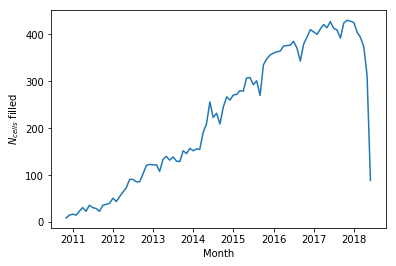

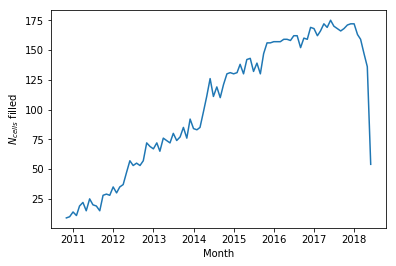

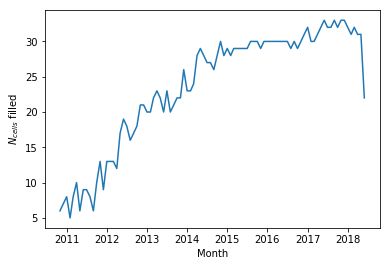

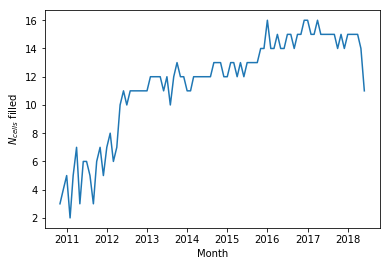

NameError: name 'jwiforen' is not defined

In [91]:
reload(IL)
for gridstep in [.5,1,3,5]:
    plt.figure()
    dates_Ncells_1, list_coords_Nposts_1 = IL.N_cells_info(df_new,gridstep)
    plt.plot(dates_Ncells_1,[e[1] for e in list_coords_Nposts_1])
    plt.xlabel('Month')
    plt.ylabel(r'$N_{cells}$ filled')
    plt.savefig('N_gridcells_step='+str(gridstep)+'.pdf')
    plt.show()
    
    steplon=gridstep/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
    steplat=gridstep/(40000./360.)

for gridstep in [.5,1,3,5]:
    break
    lng=lon1
    lonbins=[lng]
    while lng<lon2+steplon:
        lng+=steplon
        lonbins.append(lng)

    lat=lat1
    latbins=[lat]
    while lat<lat2+steplat:
        lat+=steplat
        latbins.append(lat)
    continue
        # Link the locations associated to a place in particular to visualise what it means.
    m = folium.Map(location=[np.mean(latbins),np.mean(lonbins)], zoom_start=12)
    for lng in lonbins:
        folium.PolyLine(locations=((min(latbins),lng),(max(latbins),lng)),weight=1).add_to(m)
    for lat in latbins:
        folium.PolyLine(locations=((lat,min(lonbins)),(lat,max(lonbins))),weight=1).add_to(m)
    #m.save('grid_'+str(gridstep)+'.html') 

# Term vector building by NMF

Stemming = removing all suffixes in the word to keep only its root.

This part executes NMF on time slices of the data, to have an idea of what the output might be. It generates .mat files that can be used by matlab.

More about NMF here: https://scikit-learn.org/stable/modules/decomposition.html#nmf

In [92]:
words_monuments=['parcodelvalentino','valentino','parcodora','dora','venaria',
                 'venariareale','reggiadivenaria','reggia','reale',
                 'mole','moleantonelliana','antonelliana','museodelcinema',
                 'piazzavittorio','monteideicappucini','museoegizo',
                 'palaalpitour','palazzomadama','palazzoreale',
                'piazzacastello','piazzasancarlo','piazzavittorio',]
words_added=['friends', 'italia','food','igers','igerstorino','cosa',
             'cosi','sole','instagood','picoftheday','followme','instalike',
             'likelike','focus_on','instagram','photooftheday','instadaily',
             'torino','love','italy','turin','kappafuturfestival','kff','torinocomics',
            'lingotto','followfollow','foodporn','instafood','foodgasm','stadium',
             'juventusstadium','tagsforlikes','instamood','follow','madre','granmadre']
words_filtered=list(set(['juventus', 'finoallafine', 'juventusstadium', 'juve',
'stadium', 'forzajuve', 'football', 'serie', 'bianconero', 'championsleague','instaitaly',
'solo','cosa','cosi','oggi','allianzstadium','antonelliana','followback','followers',
'followforfollow','foodblogger','foodlover','foodpic','foodpics','foodstagram',
'igdaily','igersitalia','igersitaly','igersoftheday','igerspiemonte','igersturin',
'igeuropa','igitalia','igitaly','igpiemonte','igtorino','igtravel','igturin','igworldclub',
'insta','instaart','instacool','instaday','instafashion','instafollow','instag',
'instagramers','instagramhub','instagrammers','instaitalia','instalife','instalove',
'instamoment','instamusic','instaphoto','instapic','instatorino','instatravel',
'instatraveling','iphoneonly','italia','italiainunoscatto','italian','italianfood',
'italiangirl','italianplaces','italianstyle','like','likeback','likefollow',
'likeforfollow','likeforlik','likes','likesforlikes','likeslikes','palestro',
'sansalvario','salonedelgusto','tag','tags','tagsforlikesapp',
'travel','travelblogger','travelgram','traveling','travelingram','travelling',
'travelphotography','vittorio','webstagram',u'\u0438\u0442\u0430\u043b\u0438\u044f',
u'\u043d\u0430',u'\u043d\u0435',u'\u0442\u0443\u0440\u0438\u043d',u'\u0447\u0442\u043e']))

In [93]:
from nltk.corpus import stopwords
french_stopwords = set(stopwords.words('french')) #le la les ou å pour etc.
english_stopwords = set(stopwords.words('english'))
italian_stopwords = set(stopwords.words('italian'))
from nltk.stem.snowball import FrenchStemmer
import nltk.data #
nltk.download('punkt')
from nltk.stem.snowball import FrenchStemmer
#Filter out the monuments?
monuments=False
all_stopwords=french_stopwords.union(english_stopwords)
all_stopwords=all_stopwords.union(italian_stopwords)
all_stopwords=all_stopwords.union(words_added)
all_stopwords=all_stopwords.union(words_filtered)
if monuments:
    all_stopzords=all_stopwords.union(words_monuments)

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


More info about countvectorizer here: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

And about TfIdf: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

And about NMF:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [94]:
italian_stemmer = nltk.stem.SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    # This class is basically a CountVectorizer class that has been enhanced with a stemmer method.
    def build_analyzer(self):
        #Use super to access the method build_analyzer form the class CountVectorizer.
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

In [95]:
list_reviews_all=df_classified.result.tolist()

In [96]:
n_features=1000
#Build the vectorizer and the list of all words in the dataset
#df_new=pd.read_pickle('Tor_instagram_2.pkl')
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords)
while '' in list_reviews_all:
    list_reviews_all.remove('')
while "" in list_reviews_all:
    list_reviews_all.remove("")

In [14]:
#pickle.dump(df_classified, open('df_granularity.pkl','wb'))

In [97]:
#counts = vectorizer_s.fit_transform(list_reviews_all)
#pickle.dump(counts, open('counts_master.pkl','wb'))
#pickle.dump(vectorizer_s, open('vec_s_master.pkl','wb'))
counts = pickle.load( open( 'counts_master.pkl', "rb" ) )
vectorizer_s = pickle.load( open( 'vec_s_master.pkl', "rb" ) )

In [109]:
# Feed the vectorizer with all the words in the dataset. Counts is the tweet/term matrix.
# fit_transform: fit first (build the features list with the relevant words)
# then transform: build the tweet/term matrix with the relevant tokens.

vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
voc_vector={k:v for v,k in vectorizer_s.vocabulary_.iteritems()}
voc_serie=pd.Series(voc_vector)

In [110]:
def NTF_sampling(sampling,df_classified,flags,start,stop,vectorizer_new=0,n_topics=10):
    # Feed the vectorizer with all the words in the dataset. Counts is the tweet/term matrix.
    # fit_transform: fit first (build the features list with the relevant words)
    # then transform: build the tweet/term matrix with the relevant tokens.
    if not vectorizer_new:
        print 'No vectorizer defined. Returning None'
        return None

    Coord_CRS_global=[]
    Data_CRS_global=[]
    Ncells=[]
    snapshots=df_classified.columns.tolist()[0:-1]
    if start-stop <=0:
        print 'incorrect start and stop dates. performing NTF on whole passed dataset'
        stop=len(snapshots)
    if sampling:
        list_reviews_rest=set(df_classified[start].tolist())
        try:
            list_reviews_rest.remove('')
        except KeyError:
            pass
        B = [a.split(',') for a in list(list_reviews_rest)]
        list_reviews_rest=[]
        for b in B:
            for e in b:
                list_reviews_rest.append(e)
        threshold = len(list_reviews_rest)
        print 'The threshold is', threshold
    else:
        start=0
        stop=len(snapshots)
        
    #For every snapshot takensn
    
    print snapshots[start:stop], start, stop
    for month in snapshots[start:stop]:
        print flags[snapshots.index(month)]
        print snapshots.index(month)
        try:
            # Find the vocabulary associated to each bin for the current month
            list_reviews_rest=set(df_classified[month].tolist())
            if sampling:
                This_Month=[]
                list_reviews_rest.remove('')
                B = [a.split(',') for a in list(list_reviews_rest)]
                list_reviews_rest=[]
                for b in B:
                    for e in b:
                        list_reviews_rest.append(e)
                if threshold<len(list_reviews_rest):
                    choices=[np.random.randint(0,len(list_reviews_rest)) for i in xrange(threshold)]
                    This_Month=[list_reviews_rest[i] for i in choices]
                else:
                    This_Month=list_reviews_rest
            else:
                This_Month=list_reviews_rest
            #print len(list_reviews_rest), 'tagged cells for ', year_month
        except KeyError:
            print 'KeyError has occured for ', year_month
            continue

        # Learn the vocabulary dictionary and return term-document matrix.
        print len(This_Month)
        counts = vectorizer_new.transform(This_Month)
        #Transform a count matrix to a normalized tf-idf representation. 
        #(i.e terms with frequencies too hi or lo are removed)
        # Weights are indexed by (postID, term): weight
        tfidf = TfidfTransformer().fit_transform(counts)
        #print 'tfidf done:'
        #print tfidf
        C,D=IL.read_CRS_totensor(tfidf,n_features,snapshots.index(month),10)
        #print 'C,D'#, C,D
        Coord_CRS_global.append(C)
        Data_CRS_global.append(D)
        Ncells.append(len(list_reviews_rest))
        
    triples=[]
    triples_data=[]
    #For every month in the timeline
    for i in range(0,len(Coord_CRS_global)):
        c=Coord_CRS_global[i]
        # For every post in this month
        for e in c:
            #Add the non-zero elements coordinates
            triples.append(e)

    for d in Data_CRS_global:
        for e in d:
            triples_data.append(e)
    triples=[list(i) for i in triples]
    try:
        maxNcells=max([e[0] for e in triples])
    except ValueError:
        print 'no non-zero element. returning None'
        print triples
    # Build a sktensor, which is ncp friendly. The dimensions have to be
    # N_posts_total x n_features x N_months.
    # N_months = len(Nposts) e.g, or len(Coord_CRS_global)
    # N_posts_total=sum(Nposts)
    # 
    X = sktensor.sptensor(tuple(list(np.asarray(triples).T)), triples_data, shape=(maxNcells+1, n_features, len(set(df_new_index.month_abs))))
    X_approx_ks = ncp.nonnegative_tensor_factorization(X, n_topics, method='anls_bpp')
    A = X_approx_ks.U[0]
    B = X_approx_ks.U[1]
    C = X_approx_ks.U[2]
    
    voc_vector={k:v for v,k in vectorizer_s.vocabulary_.iteritems()}
    voc_serie=pd.Series(voc_vector)
    TermVectors=[]
    TermVectorsIndex=[]
    for row in B.T:
        row=list(row)
        row = [(r,row.index(r)) for r in sorted(row)[::-1]]
        TermVectors.append(set([voc_vector[e[1]] for e in row]))
        TermVectorsIndex.append([(voc_vector[e[1]],e[0]) for e in row])
    for i in range(0,len(TermVectorsIndex)):
        TermVectorsIndex[i].sort(key=lambda tup:tup[1])
        TermVectorsIndex[i]=TermVectorsIndex[i][::-1]
    return A,B,C,TermVectorsIndex

In [112]:
vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
voc_vector={k:v for v,k in vectorizer_s.vocabulary_.iteritems()}
voc_serie=pd.Series(voc_vector)
#F = open('termvectors_sampling_5topics.txt','a') 
start=20
n_topics=15
for sample_run in xrange(1):
    A,B,C,TermVectorsIndex = NTF_sampling(False,df_classified,flags,0,0,vectorizer_new=vectorizer_new,n_topics=n_topics)
    for tvi in TermVectorsIndex:
        print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:8]]
#        F.write(str([t[0] for t in tvi[0:10]]))
#        F.write('\n')
#F.close()

incorrect start and stop dates. performing NTF on whole passed dataset
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91] 0 92
2010-10-01 00:00:00
0
10
2010-11-01 00:00:00
1
16
2010-12-01 00:00:00
2
18
2011-01-01 00:00:00
3
16
2011-02-01 00:00:00
4
24
2011-03-01 00:00:00
5
32
2011-04-01 00:00:00
6
24
2011-05-01 00:00:00
7
37
2011-06-01 00:00:00
8
32
2011-07-01 00:00:00
9
30
2011-08-01 00:00:00
10
24
2011-09-01 00:00:00
11
37
2011-10-01 00:00:00
12
39
2011-11-01 00:00:00
13
41
2011-12-01 00:00:00
14
52
2012-01-01 00:00:00
15
45
2012-02-01 00:00:00
16
55
2012-03-01 00:00:00
17
65
2012-04-01 00:00:00
18
74
2012-05-01 00:00:00
19
92
2012-06-01 00:00:00
20
92
2012-07-01 00:00:00
21
86
201

In [107]:
triples=[]
triples_data=[]
#For every month in the timeline
for i in range(0,len(Coord_CRS_global)):
    c=Coord_CRS_global[i]
    # For every post in this month
    for e in c:
        #Add the non-zero elements coordinates
        triples.append(e)

for d in Data_CRS_global:
    for e in d:
        triples_data.append(e)
triples=[list(i) for i in triples]
maxNcells=max([e[0] for e in triples])

In [108]:
#How many non-zero components in the final tensor?
np.shape(triples_data), np.shape(triples), sum(Ncells)

((4563,), (4563, 3), 2039701)

In [109]:
# Build a sktensor, which is ncp friendly. The dimensions have to be
# N_posts_total x n_features x N_months.
# N_months = len(Nposts) e.g, or len(Coord_CRS_global)
# N_posts_total=sum(Nposts)
# 
X = sktensor.sptensor(tuple(list(np.asarray(triples).T)), triples_data, shape=(maxNcells+1, n_features, len(set(df_new_index.month_abs))))

### Checkpoint

In [190]:
# pickle.dump(X, open('X.pkl','wb'))
# X = pickle.load( open( 'X.pkl', "rb" ) )
# vectorizer_s = pickle.load( open( 'vec_s.pkl', "rb" ) )

In [110]:
X_approx_ks = ncp.nonnegative_tensor_factorization(X, 15, method='anls_bpp')

In [111]:
A = X_approx_ks.U[0]
B = X_approx_ks.U[1]
C = X_approx_ks.U[2]

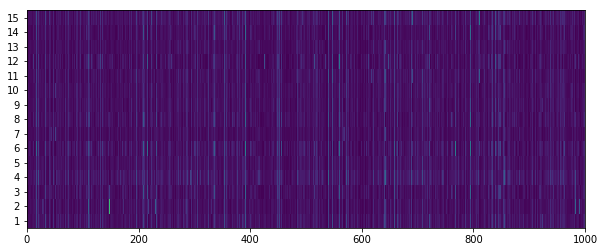

In [113]:
#Topics definition
plt.figure(figsize=(10,4))
plt.pcolormesh(B.T)#, cmap=plt.cm.Greys)
plt.xlim(0,B.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(1,B.shape[1]+1))
#plt.savefig('Topic_definition_normalized.pdf')
plt.show()

#for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
#    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [113]:
voc_vector={k:v for v,k in vectorizer_s.vocabulary_.iteritems()}
voc_serie=pd.Series(voc_vector)

In [114]:
TermVectors=[]
TermVectorsIndex=[]
for row in B.T:
    row=list(row)
    row = [(r,row.index(r)) for r in sorted(row)[::-1]]
    TermVectors.append(set([voc_vector[e[1]] for e in row]))
    TermVectorsIndex.append([(voc_vector[e[1]],e[0]) for e in row])

In [115]:
for i in range(0,len(TermVectorsIndex)):
    TermVectorsIndex[i].sort(key=lambda tup:tup[1])
    TermVectorsIndex[i]=TermVectorsIndex[i][::-1]

In [116]:
np.shape(TermVectorsIndex)

(15, 1000, 2)

In [117]:
for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:8]]

0 [u'moleantonellian', u'el', u'alessandr', u'visit', u'cinem', u'mol', u'museum', u'muse']
1 [u'super', u'retr', u'summer', u'bell', u'bio', u'ris', u'ross', u'light']
2 [u'moleantonellian', u'iphon', u'iphones', u'art', u'phot', u'sweet', u'photography', u'building']
3 [u'win', u'drink', u'night', u'girl', u'perfect', u'vin', u'solocosebell', u'goodnight']
4 [u'sush', u'ball', u'city', u'eat', u'yummy', u'piazz', u'torinocity', u'architectur']
5 [u'architectur', u'happy', u'bell', u'day', u'city', u'beautiful', u'night', u'amic']
6 [u'iphon', u'iphones', u'cool', u'photography', u'cak', u'coffe', u'night', u'pur']
7 [u'piazz', u'castell', u'sky', u'cucin', u'architectur', u'archilovers', u'beautiful', u'moleantonellian']
8 [u'dinner', u'nic', u'city', u'buongiorn', u'viagg', u'view', u'restaurant', u'style']
9 [u'parc', u'tbt', u'piedmont', u'valentin', u'piemont', u'art', u'phot', u'music']
10 [u'po', u'manc', u'art', u'fium', u'iphon', u'spring', u'ottobr', u'cia']
11 [u'mol', u'mo

In [33]:
CommonWords=set([])
for t in TermVectors:
    for t_other in TermVectors:
        if t_other!=t:
            for term in t.union(t_other):
                CommonWords.add(term)

In [34]:
for t in TermVectors:
    T=list(t)
    print len(t)
    for word in t:
        if word in CommonWords:
            T.remove(word)
    t=set(T)
    print len(T)

753
0
732
0
629
0
860
0
688
0
734
0
862
0
718
0
751
0
721
0
626
0
772
0
771
0
648
0
574
0


In [35]:
[]
for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0].encode('utf-8') for t in tvi[0:10]]

0 ['fashion', 'shopping', 'style', 'via', 'outfit', 'nuov', 'shoes', 'shop', 'hair', 'newcollection']
1 ['natur', 'parc', 'park', 'sun', 'autumn', 'sunset', 'green', 'river', 'sky', 'po']
2 ['tatto', 'ink', 'inked', 'tattoos', 'tatuagg', 'traditionaltatto', 'tattooed', 'art', 'drawing', 'black']
3 ['sempr', 'quand', 'giorn', 'vit', 'cos', 'graz', 'bell', 'prim', 'amic', 'mai']
4 ['gym', 'fitness', 'workout', 'training', 'palestr', 'sport', 'allen', 'motivation', 'fit', 'lifestyl']
5 ['pizz', 'dinner', 'yummy', 'food', 'cen', 'delicious', 'eat', 'sweet', 'cak', 'restaurant']
6 ['architectur', 'piemont', 'city', 'torino\xc3\xa8lamiacitt', 'art', 'volgotorin', 'beautiful', 'sky', 'view', 'volgopiemont']
7 ['concert', 'music', 'liv', 'spaz', 'rock', 'livemusic', 'tour', 'band', 'teatr', 'show']
8 ['pol', 'laure', 'university', 'graduation', 'design', 'architectur', 'stud', 'univers', 'day', 'vscocam']
9 ['superg', 'basil', 'panoram', 'piemont', 'natur', 'landscap', 'view', 'sunset', 'sky',

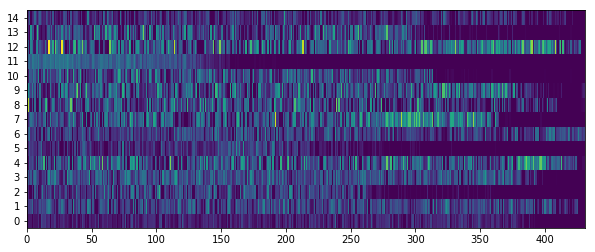

14 [u'spring', u'torino\xe8lamiacitt', u'primaver', u'beautiful', u'natur']
13 [u'summer', u'smil', u'happy', u'beautiful', u'fun']
12 [u'fashion', u'happy', u'art', u'beautiful', u'photography']
11 [u'iphones', u'night', u'sky', u'bestoftheday', u'po']
10 [u'spring', u'natur', u'music', u'photography', u'sempr']
9 [u'autumn', u'torino\xe8lamiacitt', u'happy', u'fashion', u'beautiful']
8 [u'summer', u'beautiful', u'happy', u'smil', u'estat']
7 [u'smil', u'happy', u'beautiful', u'cut', u'amazing']
6 [u'autumn', u'halloween', u'art', u'photography', u'autunn']
5 [u'happy', u'self', u'smil', u'beautiful', u'summer']
4 [u'sempr', u'fashion', u'piemont', u'music', u'beautiful']
3 [u'photography', u'music', u'sempr', u'art', u'tatto']
2 [u'beautiful', u'smil', u'happy', u'amazing', u'night']
1 [u'natal', u'christmas', u'winter', u'buon', u'dicembr']
0 [u'summer', u'beautiful', u'torino\xe8lamiacitt', u'happy', u'fashion']


In [114]:
#Topics by bin
plt.figure(figsize=(10,4))
plt.pcolormesh(A.T)#, cmap=plt.cm.Greys)
plt.xlim(0,A.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(0,B.shape[1]+1))
#plt.savefig('Topic_bybin_normalized.pdf')
plt.show()

for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [ ]:
for index in range(0,len(A.T)):
    row=A.T[index]
    print 'topic',index, '[',min(row),';', max(row)*100,']'

In [88]:
#Geographical repartition of topics
for index in range(0,len(A.T)):
    row=A.T[index]
    Coordinates=list(df_classified.index)
    x=sorted(set([Cd[0] for Cd in Coordinates]))
    y=sorted(set([Cd[1] for Cd in Coordinates]))
    z=[(Coordinates[i], row[i]) for i in range(0,len(row))]
    hem=np.zeros((len(x),len(y)))
    for e in z:
        hem[x.index(e[0][0])][y.index(e[0][1])]=e[1]
    hmap = folium.Map(location=[np.mean(x), np.mean(y)], zoom_start=10, )

    hm_wide = HeatMap( list(zip([C[0] for C in Coordinates],[C[1] for C in Coordinates],row)),
                       min_opacity=0,
                           max_val=max(row),
                       radius=15, blur=0, 
                       max_zoom=1, 
                     )
    hmap.add_child(hm_wide)

    hmap.save('Heatmaps/heatmap_topic'+str(index)+'_normalized.html')

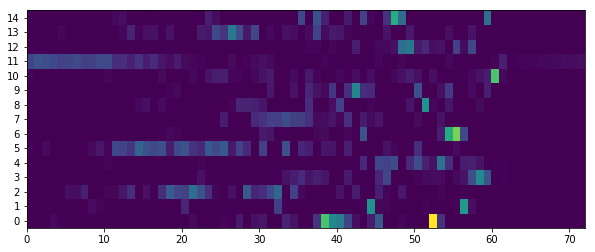

14 [u'spring', u'torino\xe8lamiacitt', u'primaver', u'beautiful', u'natur']
13 [u'summer', u'smil', u'happy', u'beautiful', u'fun']
12 [u'fashion', u'happy', u'art', u'beautiful', u'photography']
11 [u'iphones', u'night', u'sky', u'bestoftheday', u'po']
10 [u'spring', u'natur', u'music', u'photography', u'sempr']
9 [u'autumn', u'torino\xe8lamiacitt', u'happy', u'fashion', u'beautiful']
8 [u'summer', u'beautiful', u'happy', u'smil', u'estat']
7 [u'smil', u'happy', u'beautiful', u'cut', u'amazing']
6 [u'autumn', u'halloween', u'art', u'photography', u'autunn']
5 [u'happy', u'self', u'smil', u'beautiful', u'summer']
4 [u'sempr', u'fashion', u'piemont', u'music', u'beautiful']
3 [u'photography', u'music', u'sempr', u'art', u'tatto']
2 [u'beautiful', u'smil', u'happy', u'amazing', u'night']
1 [u'natal', u'christmas', u'winter', u'buon', u'dicembr']
0 [u'summer', u'beautiful', u'torino\xe8lamiacitt', u'happy', u'fashion']


In [115]:
#Topics Dynamics
plt.figure(figsize=(10,4))
plt.pcolormesh([c[start:] for c in C.T])#, cmap=plt.cm.Greys)
plt.xlim(0,len(C.T[0])-start)
#plt.savefig('Topic_dynamic.pdf')
plt.yticks(np.arange(n_topics)+0.5, np.arange(0,n_topics));
#plt.xticks()
plt.show()
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

Timestamp('2014-09-01 00:00:00')

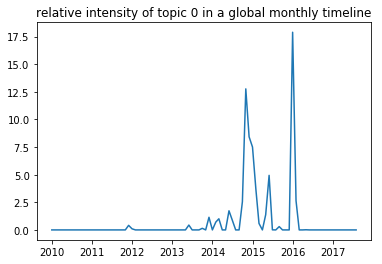

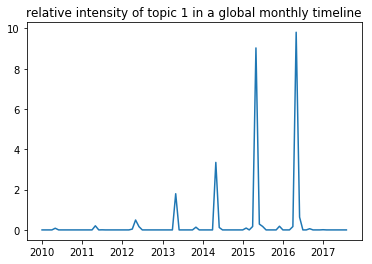

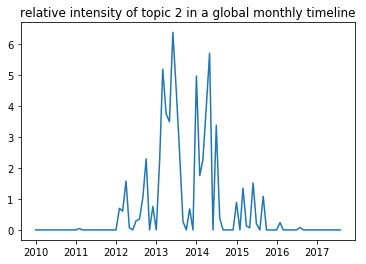

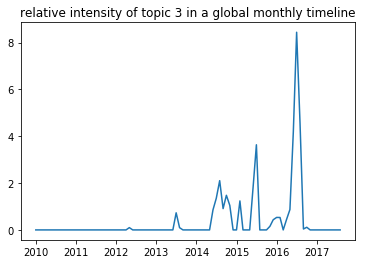

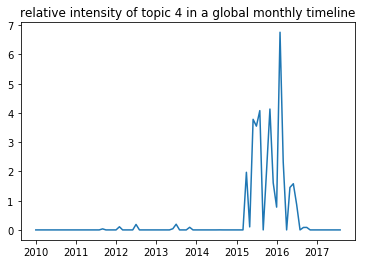

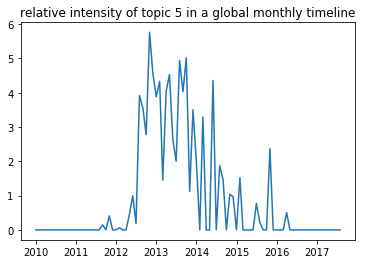

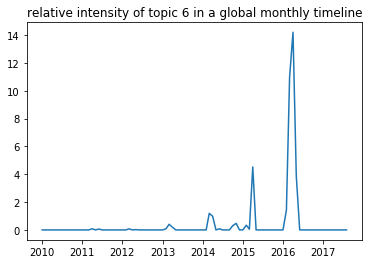

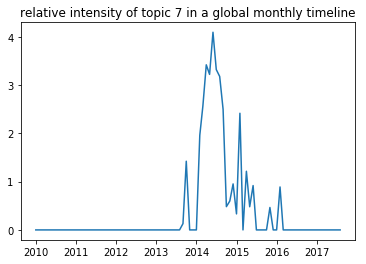

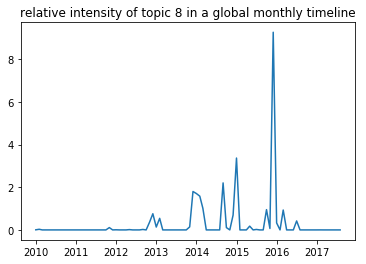

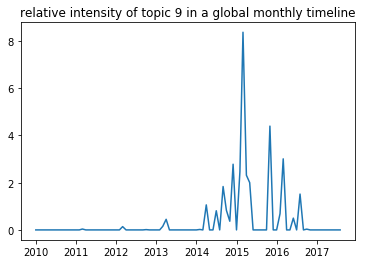

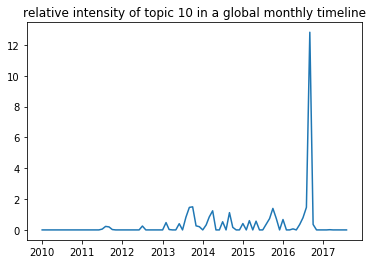

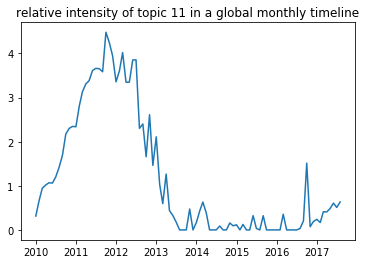

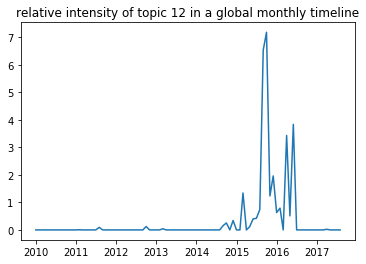

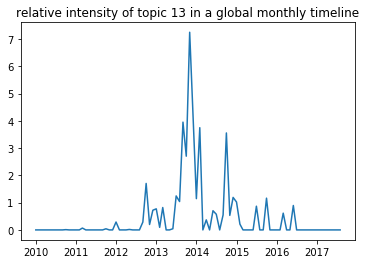

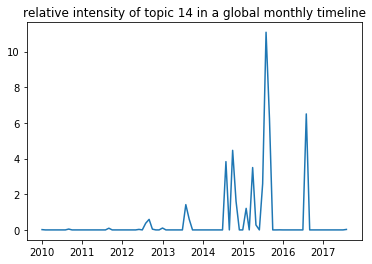

In [122]:
os.mkdir('sample_timelines')
for index in range(0, len(C.T)):
    row=C.T[index]
    plt.figure()
    plt.plot([abs_to_yearmonth(i) for i in range(0,len(row))], row)
    plt.title('relative intensity of topic '+str(index)+' in a global monthly timeline')
    plt.savefig('sample_timelines/plot_topic'+str(index)+'.pdf')
    plt.show()

In [ ]:
dfa = pd.DataFrame(A).groupby(voc_serie).sum()
#dfa = dfa[dfa.index!='teachers']

In [ ]:
dfa

In [ ]:
plt.figure(figsize=(10,4))
plt.pcolormesh(C.T)#, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(np.arange(14)+0.5, np.arange(1,15));

In [ ]:
import scipy.io
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.io import savemat
n_features=1000
n_topics=10

list_reviews_all=df_new['text'].tolist()
counts = vectorizer_s.fit_transform(list_reviews_all)
vectorizer_new = CountVectorizer(max_df=0.95, max_features=n_features,stop_words=all_stopwords_add,vocabulary=vectorizer_s.vocabulary_)
ct=0

# For each month in the dataset, get a snapshot view of the NMF tensor:
for month in range(1,(len(list_years)-1)*12+2,3):
    
    year_start=list_years[0]+ int(month/12)
    month_start=month%12  
    year_end=list_years[0]+ int(month+11-0.5)/12
    month_end=1+(month+11-1)%12
    
    try:
        list_reviews_rest=dataframe_collection[str(year_start) + '-' + str(month_start)]['text'].tolist()
    except KeyError:
        continue
        
    # Learn the vocabulary dictionary and return term-document matrix.
    counts = vectorizer_new.fit_transform(list_reviews_rest)
    
    #Transform a count matrix to a normalized tf-idf representation. 
    #(mainly =Terms with frequencies too hi or lo are removed)
    tfidf = TfidfTransformer().fit_transform(counts)
    
    #Save the data in matlab friendly format
    savemat('Inst500Matr' + str(ct), {'tfidf':tfidf})
    
    
    nmf = decomposition.NMF(n_components=n_topics)
    
    #We are looking for two matrices whose product approximates tfidf.
    
    # Learn the model (parameters etc.). I.e "take a look at what we have". returns nothing.
    W = nmf.fit(tfidf)
    
    # dictionary (factorization matrix)
    H = nmf.components_
    
    # Extracts the data and performs NMF on the tfidf-treated dataset. 
    # Returns the matrix W (the weight matrix), to be multiplied by the matrix H (dictionary) to get target tfidf.
    X2 = nmf.fit_transform(tfidf)
    ct=ct+1
    feature_names = vectorizer_new.get_feature_names()
    print month
    for i,text_topic in enumerate(X2.T):
        
        # i.e -> i, [content of column i of X2]
        # i-th topic named text_topic
        # Why sort them backwards?
        text_top = text_topic.argsort()[:-21:-1]
        word_top = nmf.components_[i].argsort()[:-11:-1]
        
        # For each text topic in the NMF resulting list, print the weight vector and the term vector.
        print [nmf.components_[i,k] for k in nmf.components_[i].argsort()[:-11:-1]]
        print [", ".join([feature_names[i] for i in word_top])]
        
        # print the amount of non-zero components in the weight vector
        l=[text_topic[i] for i in text_top]
        print np.count_nonzero(l)
            

In [ ]:
>>> import numpy as np
>>> X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
>>> from sklearn.decomposition import NMF
>>> model = NMF(n_components=2, init='random', random_state=0)
>>> W = model.fit_transform(X)
>>> H = model.components_

In [ ]:
X

In [ ]:
for i, t in enumerate(X):
    print i,t

In [ ]:
print feature_names

In [ ]:
#save the feature names in a csv file
type(feature_names)
import io

f = io.open('test_inst_Torino.csv', 'w', encoding='utf8')
for item in feature_names:
    print item
    f.write("%s\n" % item)

In [ ]:
#Boundaries of the map
print (df_new['lonbin'].min()-step_lon/2., df_new['latbin'].min()-step_lat/2., df_new['lonbin'].max()+step_lon/2., df_new['latbin'].max()+step_lat/2)

In [ ]:
len(df_new_nodup_cells['n'].unique())
list_rc=df_new_nodup2_cells['n'].tolist()
with open('n_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_rc))

In [ ]:
list_rc

In [ ]:
df_new_nodup2_cells

In [ ]:
df_new_nodup2_cells.head()

In [ ]:
import time
import datetime
list_time=[]
for month in range(1,(len(list_years)-1)*12+2,3):
        year_start=list_years[0]+ int(month/12)
        month_start=month%12  
        year_end=list_years[0]+ int(month+11-0.5)/12
        month_end=1+(month+5-1)%12
             
     
        if month_end in([2,4,6,9,11]):
            day=30
        else:
            day=31
        deb=str(year_start) + '-' + str(month_end) + '-1'
        deb_new=time.mktime(datetime.datetime.strptime(deb, "%Y-%m-%d").timetuple())
        if month==1:
            list_time= np.append(deb_new,list_time)
        else:
            list_time=np.append(list_time,deb_new)


In [ ]:
print list_time

In [ ]:

with open('times_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_time))